<a></a>
# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import numpy.ma as ma
import os
import gc
import seaborn as sns
from scipy import sparse

import tensorflow as tf

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_percentage_error, mean_squared_error

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
#path to dataset in google drive
data_path = "/kaggle/input/movielensml-latest27m/Movie Recommendation System-20221208T132444Z-001/Movie Recommendation System"


<a></a>
# Import Data

1. Dataset (ml-latest) from MovieLens, a movie recommendation service, describes 5-star rating and free-text tagging activity. 

2. It contains 27.7M ratings and 1.1M tag applications across 58098 movies. These data were created by 283228 users between January 09, 1995 and September 26, 2018

3. Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

4. Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

5. Only movies with at least one rating or tag are included in the dataset.
6.  These movie ids are consistent with those used on the MovieLens web site (e.g., id 1 corresponds to the URL https://movielens.org/movies/1).

In [5]:
ratings_df = pd.read_csv(os.path.join(data_path,"ratings.csv"), encoding='utf-8', escapechar='"')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [9]:
print("shape of ratings_df: ",ratings_df.shape)

shape of ratings_df:  (27753444, 4)


In [10]:
tags_df = pd.read_csv(os.path.join(data_path,"tags.csv"), encoding='utf-8')
print("shape of tags_df: ",tags_df.shape,"\n")
tags_df.head()

shape of tags_df:  (1108997, 4) 



,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase.

In [6]:
movies_df = pd.read_csv(os.path.join(data_path,"movies.csv"), encoding='utf-8')
print("shape of movies_df: ",movies_df.shape,"\n")
movies_df.head()

shape of movies_df:  (58098, 3) 



,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
links_df = pd.read_csv(os.path.join(data_path,"links.csv"), encoding='utf-8')
print("shape of tags_df: ",links_df.shape,"\n")
links_df.head()

shape of tags_df:  (58098, 3) 



,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [13]:
genome_tags_df = pd.read_csv(os.path.join(data_path,"genome-tags.csv"), encoding='utf-8')
print("shape of genome_tags_df: ",genome_tags_df.shape,"\n")
genome_tags_df.head()

shape of genome_tags_df:  (1128, 2) 



,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [14]:
genome_scores_df = pd.read_csv(os.path.join(data_path,"genome-scores.csv"), encoding='utf-8')
print("shape of genome_scores_df: ",genome_scores_df.shape,"\n")
genome_scores_df.head()

shape of genome_scores_df:  (14862528, 3) 



,movieId,tagId,relevance
0,1,1,0.02900
1,1,2,0.02375
2,1,3,0.05425
3,1,4,0.06875
4,1,5,0.16000


# Exploratory Data Analysis ( EDA )

## Distribution of ratings (target variable)

In [15]:
min_rating = ratings_df["rating"].min()
max_rating = ratings_df["rating"].max()

print("Min rating: ",min_rating)
print("Max rating: ",max_rating)

Min rating:  0.5
Max rating:  5.0


Min. num of ratings: 441354  for rating 1.5
Max. num of ratings: 7394710  for rating 4.0



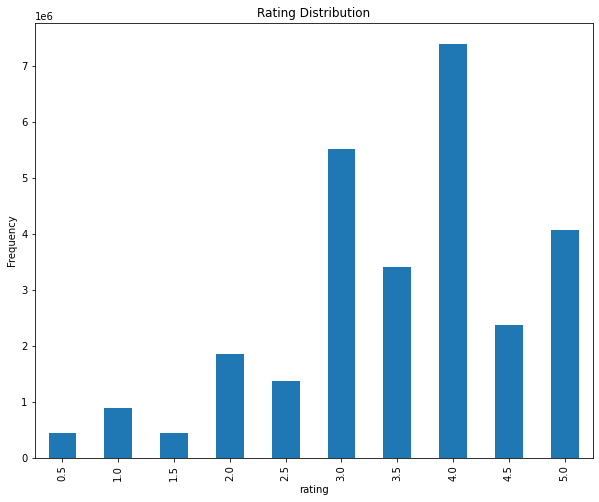

In [16]:
ratings_count = ratings_df.groupby('rating').count().userId
plt.figure(figsize=(10,8))
print(f"Min. num of ratings: {ratings_count.min()}  for rating {ratings_count.index[ratings_count.argmin()]}" )
print(f"Max. num of ratings: {ratings_count.max()}  for rating {ratings_count.index[ratings_count.argmax()]}\n" )
ratings_count.plot(kind='bar')
plt.ylabel("Frequency")
plt.title("Rating Distribution")
plt.show()

> The distribution is little left skewed.
There are less half-star ratings than full-star ratings. Most ratings are at least 3 stars.

## Frequency Distribution for average ratings of movie

<AxesSubplot:ylabel='Frequency'>

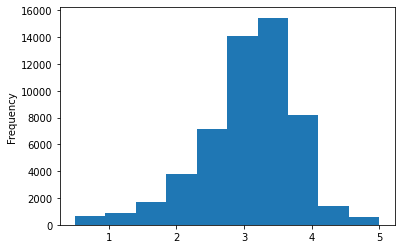

In [17]:
ratings_df.groupby('movieId').agg('mean')['rating'].plot(kind='hist')

## Number of ratings per user

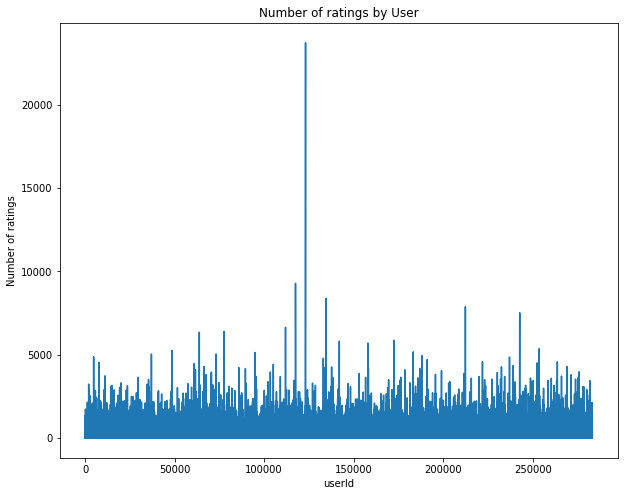

In [18]:
plt.figure(figsize=(10,8))
ratings_df.groupby('userId').agg('count')['rating'].plot(kind='line')
plt.ylabel("Number of ratings")
plt.savefig("Number of ratings by User.jpg")
plt.title("Number of ratings by User")
plt.show()

The ratings matrix is Sparse because each user only rates a small part around(3000) of total available movies(58098)

## Number of ratings for each movie

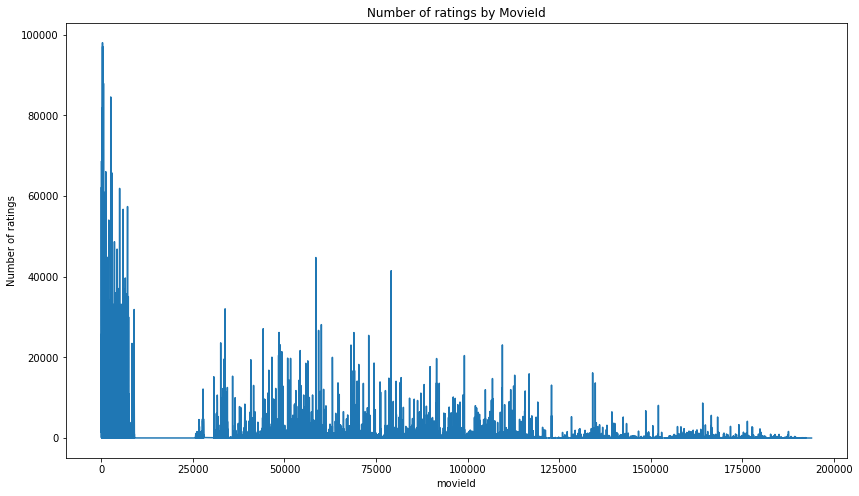

In [19]:
plt.figure(figsize=(14,8))
ratings_df.groupby('movieId').agg('count')['rating'].plot(kind='line')
plt.ylabel("Number of ratings")
plt.savefig("Number of ratings by MovieId.jpg")
plt.title("Number of ratings by MovieId")
plt.show()

Some movies are rated and watched by tens of thousands users while others are rated by few thousands times.

## Null values Check

In [20]:
ratings_df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [21]:
tags_df.isna().sum()

userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

16 null values are found in tag column which makes those data points useless. So we remove those data points.

In [22]:
tags_df.dropna(inplace=True)

In [23]:
movies_df.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [24]:
links_df.isna().sum()

movieId      0
imdbId       0
tmdbId     181
dtype: int64

In [25]:
genome_tags_df.isna().sum()

tagId    0
tag      0
dtype: int64

In [26]:
genome_scores_df.isna().sum()

movieId      0
tagId        0
relevance    0
dtype: int64

In [27]:
genome_scores_df.groupby('movieId').agg('count').value_counts()

tagId  relevance
1128   1128         13176
dtype: int64

## Common genres of movies

In [28]:
#splitting genres by | 
movies_df["genre"] = movies_df['genres'].str.split("|")

#Convert list based columns to one hot encoding
mlb = MultiLabelBinarizer()

genres_ohe = mlb.fit_transform(movies_df["genre"])
movies_df[mlb.classes_] = genres_ohe 

movies_df.head()

,movieId,title,genres,genre,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]",0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [29]:
print("Total number of Genres: ",len(mlb.classes_))
nugenres = list(mlb.classes_)
print(nugenres)

Total number of Genres:  20
['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


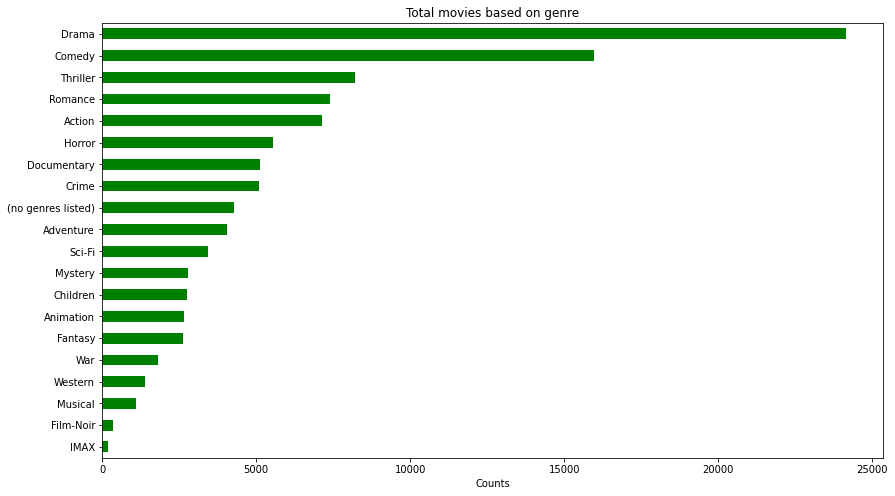

In [30]:
movies_exploded = movies_df.explode("genre")


plt.figure(figsize=(14,8))
movies_exploded['genre'].value_counts(ascending=True).plot(kind='barh',color='g')
plt.xlabel('Counts')
plt.title('Total movies based on genre')
plt.show()

In [31]:
movies_exploded

,movieId,title,genres,genre,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Animation,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Children,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Comedy,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Fantasy,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi,Horror,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi,Sci-Fi,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
58097,193886,Leal (2018),Action|Crime|Drama,Action,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58097,193886,Leal (2018),Action|Crime|Drama,Crime,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


> Drama and Comedy are the most common genres of movies followed by Thriller, Romance and others.

## Ratings by Genre

<Figure size 1152x720 with 0 Axes>

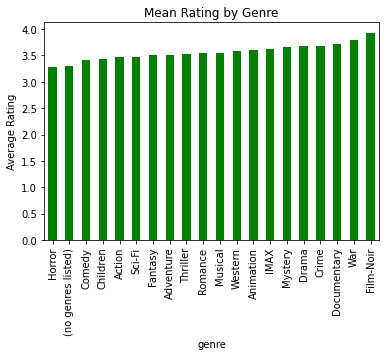

In [32]:
rating_by_genre = ratings_df[['movieId','rating']].merge(movies_exploded[['movieId','genre']], on='movieId').\
                  groupby('genre').agg({'rating':['mean']}).sort_values(('rating','mean'))

plt.figure(figsize=(16,10))
rating_by_genre.plot(kind='bar',legend=False, color='g')                  
plt.ylabel("Average Rating")
plt.title("Mean Rating by Genre")
plt.show()

> Average rating for each genre is above 3.0 i.e above neutral rating of 2.5.

In [33]:
#remove the unwanted column
#movies_df.drop(columns=["(no genres listed)","genres","genres_list"],inplace=True)

## How many movies got released in each year ?

In [34]:
#extracting the year from title
movies_df["year"] = movies_df['title'].str.extract(r'\((\d{4})\)$')
movies_df["year"].fillna(0,inplace=True)

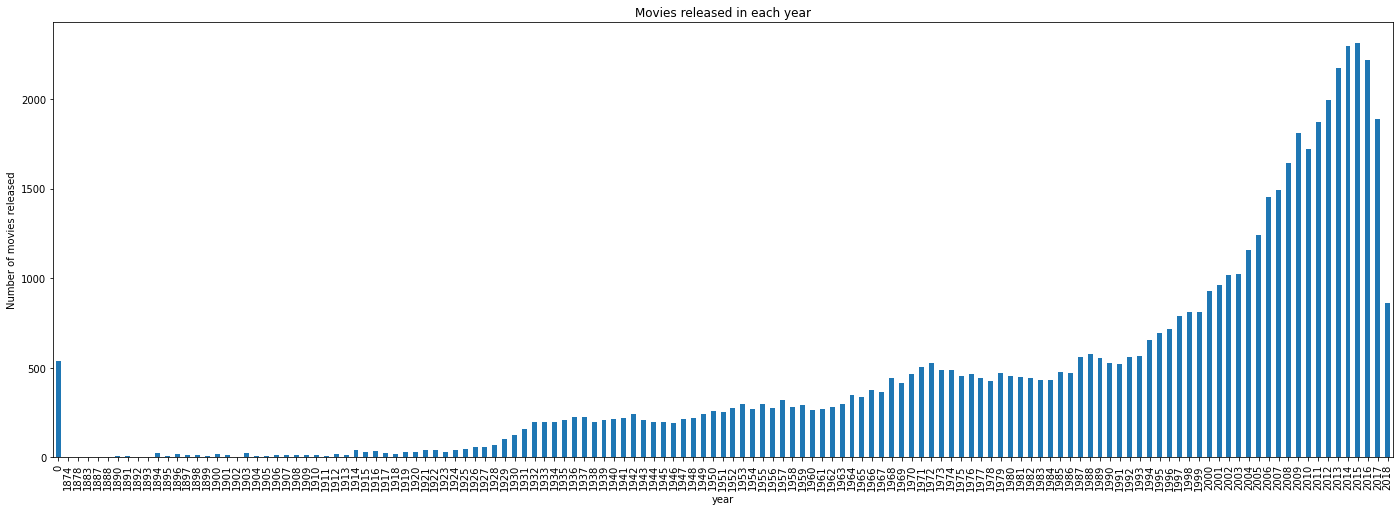

In [35]:
plt.figure(figsize=(24,8))
movies_df.groupby('year').agg('count')['movieId'].plot(kind='bar')
plt.ylabel('Number of movies released')
plt.title('Movies released in each year')
plt.show()

> The number of movies released is more or less constantly increasing from 1874 to 2015. However after 2015 there is a decrease in total movies constantly till 2018. The data may be insufficient or there may be actually a decline in total movies released after 2015.




In [36]:
genome_scores_df.groupby('movieId').agg('count').value_counts()

tagId  relevance
1128   1128         13176
dtype: int64

In [37]:
tags_df.groupby('userId').agg({'movieId':'count'})

,movieId
userId,
14,13
27,4
42,3
56,39
75,161
...,...
283184,81
283191,2
283195,9


# Collaborative Filtering Recommendation System

 The goal of a collaborative filtering recommender system is to generate two vectors: For each user, a 'parameter vector' that embodies the movie tastes of a user. For each movie, a feature vector of the same size which embodies some description of the movie. The dot product of the two vectors plus the bias term should produce an estimate of the rating the user might give to that movie.

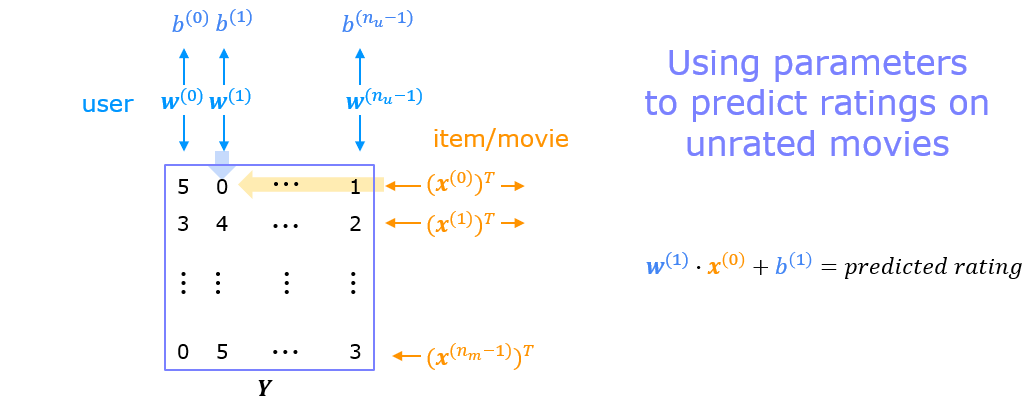

## Data Preprocessing

In [14]:
num_users = ratings_df['userId'].nunique()
num_movies = movies_df['movieId'].nunique()
print("Number of users: ",num_users)
print("Number of movies: ",num_movies)

Number of users:  283228
Number of movies:  58098


### Preprocessing to encode the user id and movie id as integer indices.

In [15]:
# mapper to get movieId given movie index
getMovieId = dict(movies_df['movieId'])
# mapper to get movie index in matrix given movie id
getMovieIdx = {value:key for key,value in getMovieId.items()}

# mapper for userId
user_ids = ratings_df["userId"].unique().tolist()
getUserId = {i:x for i,x in enumerate(user_ids)}
getUserIdx = {x:i for i,x in enumerate(user_ids)}

In [16]:
# encode movieid and userid 
ratings_df["user"] = ratings_df["userId"].map(getUserIdx)
ratings_df["movie"] = ratings_df["movieId"].map(getMovieIdx)

ratings_df["rating"] = ratings_df["rating"].values
min_rating = ratings_df["rating"].min()
max_rating = ratings_df["rating"].max()

print("Min rating: ",min_rating)
print("Max rating: ",max_rating)

Min rating:  0.5
Max rating:  5.0


### Extracting rare User Ids and Movie Ids

In [17]:
# user ids who rated only one movie
rareuserId_loc = ratings_df[["userId","movieId"]].groupby("userId").filter(lambda group:len(group)==1).index
# movie ids having only one rating
raremovieId_loc = ratings_df[["userId","movieId"]].groupby("movieId").filter(lambda group:len(group)==1).index
rareusermovie = np.union1d(rareuserId_loc, raremovieId_loc)

In [18]:
rare_df = ratings_df.iloc[rareusermovie]
df = ratings_df.drop(index=rareusermovie)

In [19]:
x = df[["user","movie"]].values
y = df["rating"].values

In [20]:
x_rare = rare_df[["user","movie"]].values
y_rare = rare_df["rating"].values

## Traning and Validation data

Since dataset size is 27M, we take 0.02% as test split. This gives around 555000 test samples.

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.02,shuffle=True, stratify=y)

In [22]:
x_train = np.concatenate((x_train,x_rare),axis=0)
y_train = np.concatenate((y_train,y_rare),axis=0).reshape(-1,1)

y_test = y_test.reshape(-1,1)

In [23]:
print("Training size: ",x_train.shape)
print("Test size: ",x_test.shape)

Training size:  (27198690, 2)
Test size:  (554754, 2)


## Normalizing Ratings between -1 and 1

Normalizing helps to 
1. Run the optimization algorithm faster.
2. Train a better model that gives reasonable predictions for new users or movies.

In [24]:
scalerTarget = MinMaxScaler((-1,1))
y_train = scalerTarget.fit_transform(y_train)
y_test = scalerTarget.transform(y_test)

In [25]:
with open("scalerTarget.pickle","wb") as f:
    pickle.dump(scalerTarget, f) 

## Model Building

In [26]:
embedding_dim = 32

class CollaborativeFilteringModel(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_dim):
        super(CollaborativeFilteringModel, self).__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_dim = embedding_dim
        self.user_embedding = tf.keras.layers.Embedding(
            num_users,
            embedding_dim,
            embeddings_initializer="uniform",
            embeddings_regularizer=tf.keras.regularizers.l2(),
        )
        self.user_bias = tf.keras.layers.Embedding(num_users, 1)
        self.movie_embedding = tf.keras.layers.Embedding(
            num_movies,
            embedding_dim,
            embeddings_initializer="uniform",
            embeddings_regularizer=tf.keras.regularizers.l2(),
        )
        self.movie_bias = tf.keras.layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.tanh(x)



In [27]:
# configure gpu

gpus = tf.config.list_physical_devices('GPU'); 
if len(gpus) == 1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.OneDeviceStrategy(device='/cpu:0')


In [28]:
# exponential decay schedule for learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01,
                                                            decay_steps=5000,
                                                            decay_rate=0.96)
# adam optimizer
adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

#with strategy.scope():
# create model
model_cfr = CollaborativeFilteringModel(num_users, num_movies, embedding_dim)

# compile the model with optimizer, loss and metrics
model_cfr.compile(
    loss=tf.keras.losses.MeanAbsoluteError(),
    optimizer=adam,
    metrics=['mse']
)

In [46]:
#with strategy.scope():
hist = model_cfr.fit(x_train,y_train, batch_size=1024, epochs=10,
                 validation_split=0.02,
                 shuffle=True)

2022-12-20 13:31:14.024543: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 426475456 exceeds 10% of free system memory.
2022-12-20 13:31:14.749420: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 426475456 exceeds 10% of free system memory.


Epoch 1/10
26030/26030 [==============================] - 200s 8ms/step - loss: 0.3539 - mse: 0.1755 - val_loss: 0.3245 - val_mse: 0.1763
Epoch 2/10
26030/26030 [==============================] - 196s 8ms/step - loss: 0.3166 - mse: 0.1703 - val_loss: 0.3145 - val_mse: 0.1747
Epoch 3/10
26030/26030 [==============================] - 195s 8ms/step - loss: 0.3089 - mse: 0.1662 - val_loss: 0.3135 - val_mse: 0.1729
Epoch 4/10
26030/26030 [==============================] - 195s 7ms/step - loss: 0.3033 - mse: 0.1630 - val_loss: 0.3084 - val_mse: 0.1715
Epoch 5/10
26030/26030 [==============================] - 195s 7ms/step - loss: 0.2992 - mse: 0.1604 - val_loss: 0.3067 - val_mse: 0.1702
Epoch 6/10
26030/26030 [==============================] - 194s 7ms/step - loss: 0.2960 - mse: 0.1584 - val_loss: 0.3048 - val_mse: 0.1692
Epoch 7/10
26030/26030 [==============================] - 194s 7ms/step - loss: 0.2936 - mse: 0.1568 - val_loss: 0.3032 - val_mse: 0.1684
Epoch 8/10
26030/26030 [==========

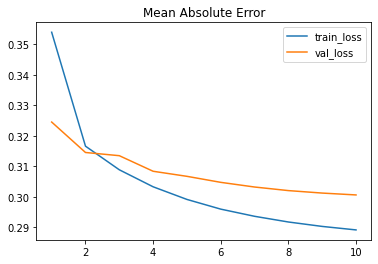

In [47]:
plt.plot(range(1,len( hist.history['loss'] )+1),hist.history['loss'],label="train_loss")
plt.plot(range(1,len( hist.history['loss'] )+1),hist.history['val_loss'],label="val_loss")
plt.title("Mean Absolute Error")
plt.legend()
plt.show()

In [48]:
model_cfr.evaluate(x_test,y_test, batch_size=256)

2168/2168 [==============================] - 6s 3ms/step - loss: 0.2918 - mse: 0.1560


[0.29179394245147705, 0.15600314736366272]

In [ ]:
y_train_pred = model_cfr.predict(x_train)
y_train_pred_ori = scalerTarget.inverse_transform(y_train_pred)
y_train_true = scalerTarget.inverse_transform(y_train)

r2score = r2_score( y_train_true, y_train_pred_ori)

mape = mean_absolute_percentage_error( y_train_true,y_train_pred_ori)

rmse = mean_squared_error(y_train_true,y_train_pred_ori ,squared=False)

print("Training Data: \n ============================================")
print("R2 Squared: ",r2score)
print("Mean Absolute Percentage Error: ",mape)
print("Root Mean Squared Error: ",rmse)

* The mae value is nearly same for all training, validation and test dataset ==> Model has not overfitted the data.

In [49]:
y_pred_test = model_cfr.predict(x_test)

r2score = r2_score(scalerTarget.inverse_transform(y_test), scalerTarget.inverse_transform(y_pred_test))

mape = mean_absolute_percentage_error(scalerTarget.inverse_transform(y_test), scalerTarget.inverse_transform(y_pred_test))
rmse = mean_squared_error(scalerTarget.inverse_transform(y_test), scalerTarget.inverse_transform(y_pred_test),squared=False)
print("Test Data: \n =====================")
print("R2 Squared : ",r2score)
print("Mean Absolute Percentage Error : ",mape)
print("Root Mean Squared Error: ",rmse)


Test Data: 
R2 Squared :  0.3053127829076744
Mean Absolute Percentage Error :  0.30260918141738036
Root Mean Squared Error:  0.8886878891357899


In [50]:
y_pred = model_cfr.predict(x_test[0:10])
y_pred = scalerTarget.inverse_transform(y_pred)
pd.DataFrame({"y_pred":y_pred.tolist(),
             "y_true":scalerTarget.inverse_transform(y_test[0:10]).tolist()})


,y_pred,y_true
0,[4.0851731300354],[4.0]
1,[3.8002779483795166],[4.0]
2,[3.9603869915008545],[3.4999999999999996]
3,[3.552946090698242],[5.000000000000001]
4,[2.827181577682495],[3.0]
5,[3.942416191101074],[3.0]
6,[2.8563528060913086],[2.0]
7,[4.146396636962891],[4.0]
8,[3.2351672649383545],[2.5000000000000004]
9,[2.3193764686584473],[1.0]


* The predicted and actual value of the ratings are nearly same with error of 0.9.

In [51]:
# save the model weights
model_cfr.save_weights("model_cfr_weights.h5")


## Top N movie recommendations to a User

In [ ]:
#with strategy.scope():
#hist = model_cfr.fit(x_train,y_train, batch_size=1024, epochs=10,
#                 validation_split=0.02,
#                 shuffle=True)

In [30]:
# load the model weights
model_cfr.load_weights("/kaggle/input/collaborative-filtering-movie-recommendation-model/model_cfr_weights.h5")

In [41]:
def get_recommendations(user_id, top_N=10, movies_df=movies_df):
    movies_watched = ratings_df[ratings_df["userId"]==user_id].movieId.unique().tolist()
    movies_not_watched = movies_df[~movies_df.movieId.isin(movies_watched)].movieId.values.tolist()
    movies_not_watched_idx = [[getMovieIdx.get(x)] for x in movies_not_watched]
    user_idx = getUserIdx.get(user_id)
    movie_user_array = np.hstack(([[user_idx]]*len(movies_not_watched_idx), movies_not_watched_idx))
    user_ratings = model_cfr.predict(movie_user_array)
    user_ratings = scalerTarget.inverse_transform(user_ratings).flatten()

    sorted_idx = np.argsort(-user_ratings).tolist()
    topNRecommendations = movies_df.iloc[sorted_idx[:top_N],:].reset_index()
    topNRecommendations["rating_pred"] = user_ratings[sorted_idx][:top_N]

    return topNRecommendations


In [42]:
top_N = 10
uid = 1007

MoviesRecommended = get_recommendations(uid, top_N)
print(f"Top{top_N} movie recommendations for user {uid}:\n")
MoviesRecommended.head(top_N)

Top10 movie recommendations for user 1007:



,index,movieId,title,genres,rating_pred
0,35617,142667,Black River (2001),Sci-Fi|Thriller,4.998482
1,36938,145763,"Il ricco, il povero e il maggiordomo (2014)",Comedy,4.995584
2,35505,142428,Winter Meeting (1948),Drama|Romance,4.994129
3,18089,90112,First Love (1939),Comedy|Musical,4.992551
4,19260,95064,House of the Rising Sun (2011),Action|Crime|Drama|Thriller,4.932662
5,33071,136706,Cinema of Vengeance (1994),(no genres listed),4.932565
6,3060,3146,Deuce Bigalow: Male Gigolo (1999),Comedy,4.928058
7,31523,133097,Orgasmo (1969),(no genres listed),4.917220
8,36171,143974,Home (2011),Drama,4.913219
9,22181,105844,12 Years a Slave (2013),Drama,4.911044


**Top 5 Movies rated by the user**

In [45]:
ratings_df[ratings_df["userId"]==uid][["userId","movieId","rating"]].sort_values(by="rating",ascending=False).head(5).merge(movies_df,on="movieId",how="left")

,userId,movieId,rating,title,genres
0,1007,3844,5.0,Steel Magnolias (1989),Drama
1,1007,3405,5.0,"Night to Remember, A (1958)",Action|Drama
2,1007,2599,5.0,Election (1999),Comedy
3,1007,539,5.0,Sleepless in Seattle (1993),Comedy|Drama|Romance
4,1007,356,5.0,Forrest Gump (1994),Comedy|Drama|Romance|War


* We can see the genre of the recommended movies matched with the genre of the top 5 movies rated by the user's

<a id="Content-based filtering Movie Recommendation System"></a>
# Content-based filtering Movie Recommendation System

Content-based filtering also generates a user and movie feature vector but recognizes there may be other information available about the user and/or movie that may improve the prediction. The additional information is provided to a neural network which then generates the user and movie vector as shown below.

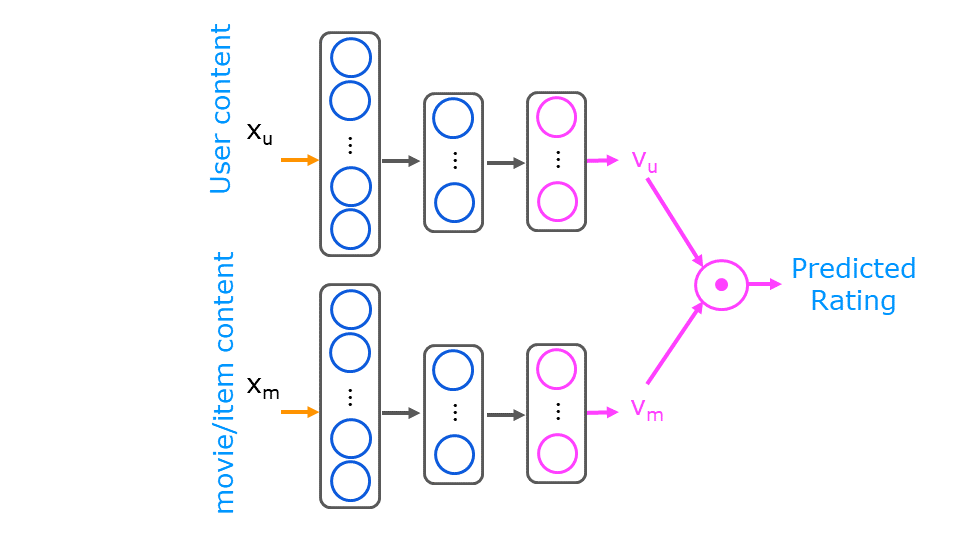

<a id="Preprocessing Data"></a>
## Preprocessing Data

### Feature Engineering for Movies

In [38]:
movie_features = movies_df.copy()
#removing unwanted columns
movie_features.drop(columns=['title','genres','genre'],inplace=True)
movie_features.head()

,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,3,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1995
3,4,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1995
4,5,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995


In [39]:
#add average rating for each movie
movie_features = movie_features.merge(ratings_df[['movieId','rating']].groupby('movieId').agg('mean').reset_index().rename(columns={'rating':'avg_rating'}),on='movieId',how='left')
#change the order of year column
movie_features = movie_features.iloc[:,[0,-2,-1]+list(range(1,len(movie_features.columns)-2))]
movie_features.head()

,movieId,year,avg_rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1995,3.886649,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1995,3.246583,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1995,3.173981,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,1995,2.874540,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,1995,3.077291,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
print("There are total ",len(movie_features.columns[1:])," features for a movie.\n")
print("Features for Movie are:\n\n",movie_features.columns[1:].values)

There are total  22  features for a movie.

Features for Movie are:

 ['year' 'avg_rating' '(no genres listed)' 'Action' 'Adventure' 'Animation'
 'Children' 'Comedy' 'Crime' 'Documentary' 'Drama' 'Fantasy' 'Film-Noir'
 'Horror' 'IMAX' 'Musical' 'Mystery' 'Romance' 'Sci-Fi' 'Thriller' 'War'
 'Western']


In [ ]:
# saving movie features as csv file
movie_features.to_csv("movie_features.csv", index=False)


### Feature Engineering for Users

#### Get Per Genre rating average for user

In [41]:
user_features = ratings_df[["userId","movieId","rating"]].merge(movies_df[["movieId","genres"]], on="movieId", how="left")
user_features["genres"] = user_features["genres"].apply(lambda x:x.split("|"))
user_features = user_features.explode(column="genres")
user_features.head()

,userId,movieId,rating,genres
0,1,307,3.5,Drama
1,1,481,3.5,Drama
1,1,481,3.5,Thriller
2,1,1091,1.5,Comedy
3,1,1257,4.5,Comedy


In [43]:
user_features = user_features.groupby(["userId","genres"]).agg({"rating":"mean"}).reset_index()

In [44]:
# create a pivot table for users having average rating for each genre
user_features = user_features.pivot(index="userId", columns="genres",values="rating")
user_features.columns.name = None
user_features.reset_index(inplace=True)
user_features.fillna(0,inplace=True)
user_features.head()

,userId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0.0,2.875000,1.500000,0.000000,0.00000,3.750000,3.000000,0.000000,3.666667,...,0.0,2.25000,0.000000,0.000000,0.000000,4.000000,2.750000,2.642857,0.000000,4.00
1,2,0.0,3.500000,3.500000,0.000000,0.00000,3.611111,3.500000,0.000000,3.812500,...,0.0,4.00000,0.000000,4.000000,0.000000,3.700000,3.500000,3.500000,3.000000,0.00
2,3,0.0,5.000000,4.000000,0.000000,4.00000,3.500000,3.500000,0.000000,3.625000,...,0.0,3.00000,0.000000,0.000000,3.500000,0.000000,0.000000,3.666667,5.000000,0.00
3,4,0.0,3.619403,3.477612,3.546875,2.46875,2.904930,3.786765,3.416667,3.603734,...,5.0,3.44898,3.833333,2.545455,3.819149,3.213483,3.474138,3.727273,3.955882,2.85
4,5,0.0,4.269231,4.285714,0.000000,0.00000,4.263158,4.338710,4.500000,4.310000,...,4.5,0.00000,4.000000,0.000000,4.318182,4.500000,4.500000,4.250000,4.375000,4.50


In [ ]:
# get the average rating user gives over all movies

#avg_user_rating = ratings_df[["userId","rating"]].groupby("userId").agg("mean").reset_index().rename(columns={"rating":"avg_rating"})
#user_features = user_features.merge(avg_user_rating, on="userId", how="left")
#user_features = user_features.iloc[:,[0,-1]+list(range(1,len(user_features.columns)-1))]
#user_features.head()

The content for uers consist of per genre rating average of the users. We have total 20 features to represent the user.

In [ ]:
#save the parameters for users

user_features.to_csv("user_features.csv", index=False)

#### Getting User's data( which movie user has rated)

In [ ]:
ratings_df = pd.read_csv(os.path.join(data_path,"ratings.csv"), encoding='utf-8', escapechar='"')

In [ ]:
user_to_movies = ratings_df[["userId","movieId"]].groupby("userId")["movieId"].apply(list).reset_index(name="MoviesRated").reset_index()
userToMoviesRated = pd.Series(user_to_movies.MoviesRated, index=user_to_movies.userId).to_dict()
with open("userToMoviesRated.pickle","wb") as f:
    pickle.dump(userToMoviesRated,f)

### Preparing Training Data

In [6]:
#load feature vectors for movie
movie_features = pd.read_csv("/kaggle/input/movielensml-latest27m/movie_features.csv")
#load parameter vector for users
user_features = pd.read_csv("/kaggle/input/movielensml-latest27m/user_features.csv")

In [7]:
num_movies = movie_features.shape[0]
num_users = user_features.shape[0]

In [8]:
X_users_data = ratings_df[["userId"]].merge(user_features, on="userId", how="left").drop(columns="userId")
X_movies_data = ratings_df[["movieId"]].merge(movie_features, on="movieId", how="left").drop(columns="movieId")
Y_ratings = ratings_df[["rating"]]

In [9]:
del movie_features, user_features, ratings_df
gc.collect()

280

### Feature Scaling

In [13]:
X_movies_scaled = X_movies_data.values

scalerMovie = StandardScaler()
X_movies_scaled[:,0:2] = scalerMovie.fit_transform(X_movies_data.iloc[:,0:2])

scalerUser = MaxAbsScaler()
X_users_scaled = scalerUser.fit_transform(X_users_data)

scalerTarget = MinMaxScaler((-1,1))
Y_ratings_scaled = scalerTarget.fit_transform(Y_ratings)

In [14]:
with open("scalerUser.pickle","wb") as f:
    pickle.dump(scalerUser, f)
with open("scalerMovie.pickle","wb") as f:
    pickle.dump(scalerMovie, f)    
with open("scalerTarget.pickle","wb") as f:
    pickle.dump(scalerTarget, f)     

In [15]:
np.savez_compressed("data",X_movies_scaled,X_users_scaled, Y_ratings_scaled)

In [ ]:
del ratings_df,X_users_data, X_movies_data, Y_ratings
gc.collect()

### Train-Test-Split

In [3]:
data = np.load("/kaggle/input/movielensml-latest27m/data.npz")

In [4]:
X_movies_scaled = data["arr_0"]
X_users_scaled = data["arr_1"]
Y_ratings_scaled = data["arr_2"]

In [5]:
x_movies_train, x_movies_test = train_test_split(X_movies_scaled, train_size=0.98, shuffle=True, random_state=1)
x_users_train, x_users_test = train_test_split(X_users_scaled, train_size=0.98, shuffle=True, random_state=1)
y_train, y_test = train_test_split(Y_ratings_scaled,    train_size=0.98, shuffle=True, random_state=1)
print(f"movie/item training data shape: {x_movies_train.shape}")
print(f"movie/item test data shape: {x_movies_test.shape}")

movie/item training data shape: (27198375, 22)
movie/item test data shape: (555069, 22)


In [6]:
del X_movies_scaled, X_users_scaled, Y_ratings_scaled
gc.collect()

139

## Model Building

In [3]:
num_user_features = 20 #x_users_train.shape[1]
num_item_features = 22 #x_movies_train.shape[1]
print("Number of user contents: ",num_user_features)
print("Number of movie contents: ",num_item_features)

Number of user contents:  20
Number of movie contents:  22


In [4]:
# configure gpu

gpus = tf.config.list_physical_devices('GPU'); 
if len(gpus) == 1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy()
else:
    #strategy = tf.distribute.OneDeviceStrategy(device='/cpu:0')
    strategy = None
  

In [5]:
num_outputs = 32

def get_model():
    input_user  = tf.keras.layers.Input(shape=(num_user_features))
    input_item = tf.keras.layers.Input(shape=(num_item_features))

    user_NN = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(256, activation = 'relu'),
        #tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(128, activation = 'relu'),
        #tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(num_outputs)
    ])

    item_NN = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(256, activation = 'relu'),
        #tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(128, activation = 'relu'),
        #tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(num_outputs)
    ])

    dotProduct = tf.keras.layers.Dot(axes=1)



    output_user = user_NN(input_user)
    vu = tf.linalg.l2_normalize(output_user,axis=1)
    output_item = item_NN(input_item)
    vi = tf.linalg.l2_normalize(output_item,axis=1)
    #output = dotProduct([vu, vi])
    
    multiplied = tf.keras.layers.Multiply()([vu, vi])
    dense1 = tf.keras.layers.Dense(64, activation='relu')(multiplied)
    dense1 = tf.keras.layers.Dropout(0.1)(dense1)
    output = tf.keras.layers.Dense(1,activation='tanh')(dense1)
    
    
    
    model = tf.keras.Model([input_user, input_item],output)
    
    return model, user_NN, item_NN


In [6]:
# exponential decay fn for the learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.005,
                                                            decay_steps=100000,
                                                            decay_rate=0.96)

adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
mae = tf.keras.losses.MeanAbsoluteError()

def rmse(y_true,y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_true,y_pred))))

if strategy:
    with strategy.scope():
        model, user_NN, movie_NN = get_model()
        model.compile(optimizer=adam, loss=mae)
else:
    model, user_NN, movie_NN = get_model()
    model.compile(optimizer=adam, loss='huber_loss', metrics=['mse'])
    
model.summary()    

2022-12-27 11:14:09.743594: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 22)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32)           72736       input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 32)           72992       input_2[0][0]                    
______________________________________________________________________________________________

In [7]:
# making a separate model for outputing user feature vector
user_inp = tf.keras.layers.Input(shape=(num_user_features))
user_out = user_NN(user_inp)
user_out = tf.linalg.l2_normalize(user_out,axis=1)

model_user = tf.keras.Model(user_inp, user_out)

# separate model to output movie feature vectors
item_inp = tf.keras.layers.Input(shape=(num_item_features))
item_out = movie_NN(item_inp)
item_out = tf.linalg.l2_normalize(item_out,axis=1)

model_movie = tf.keras.Model(item_inp, item_out)

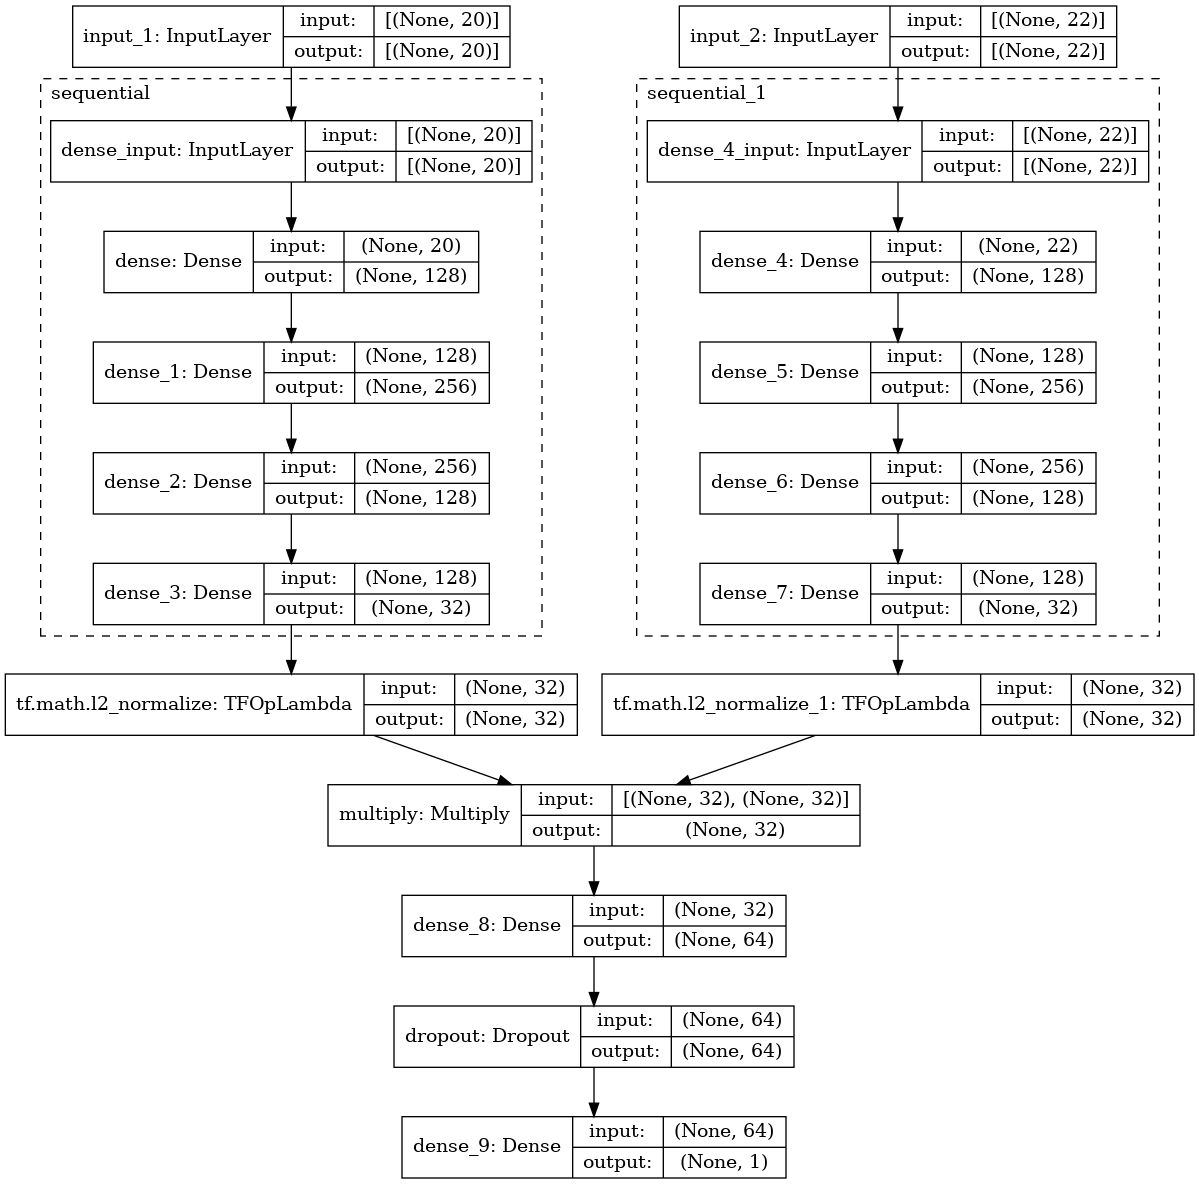

In [8]:
tf.keras.utils.plot_model(model,"model.png",show_shapes=True, expand_nested=True)

## Model Training

In [17]:
#with strategy.scope():
hist = model.fit( [x_users_train, x_movies_train],y_train, batch_size=512, epochs=10,
                validation_split=0.01,
                shuffle=True)

2022-12-26 07:27:25.984379: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
52591/52591 [==============================] - 507s 10ms/step - loss: 0.0682 - mse: 0.1374 - val_loss: 0.0654 - val_mse: 0.1317
Epoch 2/10
52591/52591 [==============================] - 505s 10ms/step - loss: 0.0652 - mse: 0.1313 - val_loss: 0.0643 - val_mse: 0.1294
Epoch 3/10
52591/52591 [==============================] - 507s 10ms/step - loss: 0.0641 - mse: 0.1290 - val_loss: 0.0630 - val_mse: 0.1268
Epoch 4/10
52591/52591 [==============================] - 506s 10ms/step - loss: 0.0631 - mse: 0.1270 - val_loss: 0.0624 - val_mse: 0.1255
Epoch 5/10
52591/52591 [==============================] - 521s 10ms/step - loss: 0.0625 - mse: 0.1258 - val_loss: 0.0617 - val_mse: 0.1242
Epoch 6/10
52591/52591 [==============================] - 519s 10ms/step - loss: 0.0620 - mse: 0.1248 - val_loss: 0.0611 - val_mse: 0.1228
Epoch 7/10
52591/52591 [==============================] - 515s 10ms/step - loss: 0.0614 - mse: 0.1236 - val_loss: 0.0608 - val_mse: 0.1223
Epoch 8/10
52591/52591 [===

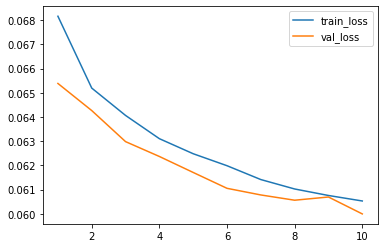

In [18]:
plt.plot(range(1,len(hist.history['loss'])+1),hist.history['loss'],label="train_loss")
plt.plot(range(1,len(hist.history['val_loss'])+1),hist.history['val_loss'],label="val_loss")
plt.legend()
plt.show()


2022-12-27 07:23:03.779108: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
26296/26296 [==============================] - 499s 19ms/step - loss: 0.0602 - mse: 0.1211 - val_loss: 0.0598 - val_mse: 0.1204
Epoch 2/20
26296/26296 [==============================] - 494s 19ms/step - loss: 0.0601 - mse: 0.1209 - val_loss: 0.0602 - val_mse: 0.1210
Epoch 3/20
26296/26296 [==============================] - 491s 19ms/step - loss: 0.0600 - mse: 0.1207 - val_loss: 0.0596 - val_mse: 0.1201
Epoch 4/20
26296/26296 [==============================] - 493s 19ms/step - loss: 0.0599 - mse: 0.1205 - val_loss: 0.0596 - val_mse: 0.1199
Epoch 5/20
26296/26296 [==============================] - 494s 19ms/step - loss: 0.0597 - mse: 0.1201 - val_loss: 0.0595 - val_mse: 0.1197
Epoch 6/20
26296/26296 [==============================] - 489s 19ms/step - loss: 0.0595 - mse: 0.1197 - val_loss: 0.0592 - val_mse: 0.1192
Epoch 7/20
26296/26296 [==============================] - 486s 18ms/step - loss: 0.0593 - mse: 0.1194 - val_loss: 0.0590 - val_mse: 0.1186
Epoch 8/20
26296/26296 [===

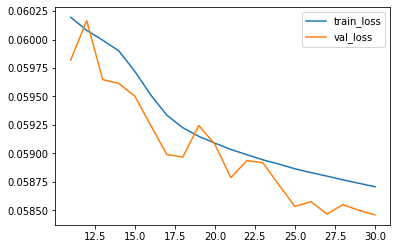

In [14]:
#with strategy.scope():

hist = model.fit([x_users_train, x_movies_train],y_train, batch_size=1024, epochs=20,
                validation_split=0.01,
                shuffle=True)
          
    
plt.plot(range(11,10+len(hist.history['loss'])+1),hist.history['loss'],label="train_loss")
plt.plot(range(11,10+len(hist.history['val_loss'])+1),hist.history['val_loss'],label="val_loss")
plt.legend()
plt.show()


In [15]:
with open("/kaggle/input/contentbased-filtering-movie-recommendation-model/scalerTarget.pickle","rb") as f:
    scalerTarget = pickle.load(f)

In [18]:
y_train_pred = model.predict([x_users_train, x_movies_train])
y_train_pred_ori = scalerTarget.inverse_transform(y_train_pred)
y_train_true = scalerTarget.inverse_transform(y_train)

r2score = r2_score( y_train_true, y_train_pred_ori)

mape = mean_absolute_percentage_error( y_train_true,y_train_pred_ori)

rmse = mean_squared_error(y_train_true,y_train_pred_ori ,squared=False)

print("Training Data: \n ============================================")
print("R2 Squared: ",r2score)
print("Mean Absolute Percentage Error: ",mape)
print("Root Mean Squared Error: ",rmse)

Training Data: 
R2 Squared:  0.4772324695690683
Mean Absolute Percentage Error:  0.2487313330785977
Root Mean Squared Error:  0.7710157914237927


## Evaluation

In [16]:
model.evaluate([x_users_test, x_movies_test],y_test, batch_size=256, steps=10000)

10000/10000 [==============================] - 8s 811us/step - loss: 0.0585 - mse: 0.1177


[0.05854157730937004, 0.1177283525466919]

In [17]:
y_pred_test = model.predict([x_users_test, x_movies_test])

r2score = r2_score(
    scalerTarget.inverse_transform(y_test), scalerTarget.inverse_transform(y_pred_test))

mape = mean_absolute_percentage_error(
    scalerTarget.inverse_transform(y_test), scalerTarget.inverse_transform(y_pred_test))

rmse = mean_squared_error(
    scalerTarget.inverse_transform(y_test), scalerTarget.inverse_transform(y_pred_test),squared=False)

print("Test Data: \n ============================================")
print("R2 Squared: ",r2score)
print("Mean Absolute Percentage Error: ",mape)
print("Root Mean Squared Error: ",rmse)

Test Data: 
R2 Squared:  0.47490611060820553
Mean Absolute Percentage Error:  0.24858016897731877
Root Mean Squared Error:  0.7720097726763933


In [22]:
y_pred = model.predict([x_users_test[0:10], x_movies_test[0:10]])
y_pred = scalerTarget.inverse_transform(y_pred)
pd.DataFrame({"y_pred":y_pred.tolist(),
             "y_true":scalerTarget.inverse_transform(y_test[0:10]).tolist()})

,y_pred,y_true
0,[3.8003270626068115],[4.0]
1,[4.4423675537109375],[4.5]
2,[3.51298189163208],[5.000000000000001]
3,[3.9294402599334717],[4.0]
4,[4.438326835632324],[5.000000000000001]
5,[2.391979217529297],[3.0]
6,[3.519301414489746],[3.0]
7,[2.419738531112671],[2.5000000000000004]
8,[3.844350814819336],[3.4999999999999996]
9,[3.0204858779907227],[3.0]


In [21]:
# save the model weights
model.save_weights("model_weights.h5")
model_user.save_weights("model_user_weights.h5")
model_movie.save_weights("model_item_weights.h5")

In [ ]:
del x_users_train,x_movies_train
gc.collect()

## Prediction

In [8]:
model, user_NN, movie_NN = get_model()

# making a separate model for outputing user feature vector
user_inp = tf.keras.layers.Input(shape=(num_user_features))
user_out = user_NN(user_inp)
user_out = tf.linalg.l2_normalize(user_out,axis=1)

model_user = tf.keras.Model(user_inp, user_out)

# separate model to output movie feature vectors
item_inp = tf.keras.layers.Input(shape=(num_item_features))
item_out = movie_NN(item_inp)
item_out = tf.linalg.l2_normalize(item_out,axis=1)

model_movie = tf.keras.Model(item_inp, item_out)

In [ ]:
# load the trained weights
model.load_weights("/kaggle/input/contentbased-filtering-movie-recommendation-model/v1/v1/model_weights.h5")
model_user.load_weights("/kaggle/input/contentbased-filtering-movie-recommendation-model/v1/v1/model_user_weights.h5")
model_movie.load_weights("/kaggle/input/contentbased-filtering-movie-recommendation-model/v1/v1/model_item_weights.h5")

In [9]:
#model.load_weights("/kaggle/working/model_weights.h5")
#model_user.load_weights("/kaggle/working/model_user_weights.h5")
#model_movie.load_weights("/kaggle/working/model_item_weights.h5")

In [10]:
# load the movies data
movies_df = pd.read_csv(os.path.join(data_path,"movies.csv"), encoding='utf-8')
#load the ratings data
ratings_df = pd.read_csv(os.path.join(data_path,"ratings.csv"), encoding='utf-8', escapechar='"')
##movies_df.set_index("movieId",inplace=True)

#load feature vectors for movie
movie_features = pd.read_csv("/kaggle/input/movielensml-latest27m/movie_features.csv")
#load parameter vector for users
user_features = pd.read_csv("/kaggle/input/movielensml-latest27m/user_features.csv")
user_features.set_index("userId",inplace=True)


In [11]:
num_movies = movie_features.shape[0]
num_users = user_features.shape[0]
print("Total Number of movies: ",num_movies)
print("Total Number of uses: ",num_users)

Total Number of movies:  58098
Total Number of uses:  283228


In [12]:
#load the scaler

with open("/kaggle/input/contentbased-filtering-movie-recommendation-model/scalerUser.pickle","rb") as f:
    scalerUser = pickle.load(f)
with open("/kaggle/input/contentbased-filtering-movie-recommendation-model/scalerMovie.pickle","rb") as f:
    scalerMovie = pickle.load(f)    
with open("/kaggle/input/contentbased-filtering-movie-recommendation-model/scalerTarget.pickle","rb") as f:
    scalerTarget = pickle.load(f)
    
with open("/kaggle/input/movielensml-latest27m/userToMoviesRated.pickle","rb") as f:
    userToMoviesRated = pickle.load(f)

In [14]:
#scale the feature vectors for movie
movie_vecs_scaled = movie_features.drop(columns="movieId").values
movie_vecs_scaled[:,0:2] = scalerMovie.transform(movie_features.drop(columns="movieId").iloc[:,0:2])

### Recommendation for a new USER

In [29]:
new_no_genres_listed = 0
new_Action = 5
new_Adventure = 4.5
new_Animation = 0
new_Children = 0
new_Comedy = 0
new_Crime = 0
new_Documentary = 0
new_Drama = 0
new_Fantasy = 0 
new_Film_Noir = 0
new_Horror = 0
new_IMAX = 0
new_Musical = 0
new_Mystery = 0
new_Romance = 0
new_Sci_Fi = 0
new_Thriller = 0
new_War = 0
new_Western = 0

user_vec = np.array([new_no_genres_listed, new_Action, new_Adventure,
                     new_Animation,new_Children,new_Comedy,new_Crime, new_Documentary ,new_Drama ,
                     new_Fantasy,new_Film_Noir,new_Horror,new_IMAX, new_Musical,new_Mystery,
                     new_Romance, new_Sci_Fi,new_Thriller, new_War,new_Western])


In [30]:
top_N = 10

def get_recommendations_new_user(user_vec, top_N, movie_vecs_scaled=movie_vecs_scaled, scalerUser=scalerUser, scalerTarget=scalerTarget):
    # replicate the user_vector to match for the number of movies 
    user_vecs = np.tile(user_vec, (movie_features.shape[0], 1))

    #scale the user vectors
    user_vecs_scaled = scalerUser.transform(user_vecs)

    y_pred = model.predict([user_vecs_scaled, movie_vecs_scaled])

    #unscale the predictions
    y_pred = scalerTarget.inverse_transform(y_pred)

    # sort the movies, highest prediction first
    sorted_idx = np.argsort(-y_pred,axis=0).reshape(-1).tolist()
    sorted_pred = y_pred[sorted_idx]
    sorted_movies = movies_df.iloc[sorted_idx].iloc[0:top_N]
    sorted_movies['rating'] = sorted_pred[0:top_N]
    
    return sorted_movies


In [31]:
print("Vector representation for a new user :")
print(scalerUser.transform(user_vec.reshape(1,-1)))

Vector representation for a new user :
[[0.  1.  0.9 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]]


In [32]:
sorted_movies = get_recommendations_new_user(user_vec, top_N, movie_vecs_scaled, scalerUser, scalerTarget)

print(f"Top {top_N} movie recommendations for given User:\n")
sorted_movies.reset_index(drop=True).head(top_N)

Top 10 movie recommendations for given User:



,movieId,title,genres,rating
0,166297,"Bagi, the Monster of Mighty Nature (Taishizen ...",Action|Adventure|Animation,4.975091
1,55995,Beowulf (2007),Action|Adventure|Animation|Fantasy|IMAX,4.968926
2,93766,Wrath of the Titans (2012),Action|Adventure|Fantasy|IMAX,4.965480
3,106072,Thor: The Dark World (2013),Action|Adventure|Fantasy|IMAX,4.961287
4,86332,Thor (2011),Action|Adventure|Drama|Fantasy|IMAX,4.956300
5,86880,Pirates of the Caribbean: On Stranger Tides (2...,Action|Adventure|Fantasy|IMAX,4.953849
6,101112,Oz the Great and Powerful (2013),Action|Adventure|Fantasy|IMAX,4.939826
7,115669,Young Detective Dee: Rise of the Sea Dragon (D...,Action|Adventure|Drama|Fantasy|Mystery|IMAX,4.933150
8,95475,Dragon Ball Z: Cooler's Revenge (Doragon bôru ...,Action|Adventure|Animation,4.931520
9,100469,Chinese Zodiac (Armour of God III) (CZ12) (2012),Action|Adventure|IMAX,4.931441


* We can see that the genre of recommended movies matched with the interest of given user.

### Recommendation for existing User

In [33]:
def get_recommendations_existing_user(uid,top_N=10,user_features=user_features,
                                      userToMoviesRated= userToMoviesRated, 
                                      movie_vecs_scaled=movie_vecs_scaled, 
                                      scalerUser=scalerUser,
                                      scalerTarget=scalerTarget):
    
    if uid in user_features.index:
        user_vec = user_features.iloc[uid]
    else:
        print("User Id is not in database.")
        return
    
    # get movieId already rated
    moviesRated = userToMoviesRated[uid]
    # replicate the user_vector to match for the number of movies 
    user_vecs = np.tile(user_vec, (movie_features.shape[0], 1))

    #scale the user vectors
    user_vecs_scaled = scalerUser.transform(user_vecs)

    y_pred = model.predict([user_vecs_scaled, movie_vecs_scaled])

    #unscale the predictions
    y_pred = scalerTarget.inverse_transform(y_pred)

    # sort the movies, highest prediction first
    sorted_idx = np.argsort(-y_pred,axis=0).reshape(-1).tolist()
    for i in moviesRated:
        sorted_idx.remove(i-1)
    
    sorted_pred = y_pred[sorted_idx]
    sorted_movies = movies_df.iloc[sorted_idx].iloc[0:top_N]
    sorted_movies['rating'] = sorted_pred[0:top_N]
    
    return sorted_movies

In [34]:
top_N = 10
uid = 1007

#print(user_features.iloc[uid],"\n")
print(f"{top_N} movie recommendations for user {uid}: \n")
rmovies = get_recommendations_existing_user(uid, top_N)
rmovies.reset_index(drop=True).head(top_N)

10 movie recommendations for user 1007: 



,movieId,title,genres,rating
0,179649,Horse Crazy (2001),Children|Drama,4.994435
1,140385,A Horse for Danny (1995),Children|Drama,4.992630
2,115017,"Christmas Memory, A (Truman Capote's 'A Christ...",Children|Drama,4.991246
3,140391,Pistol: The Birth of a Legend (1991),Children|Drama,4.990455
4,125287,Heidi (2005),Children|Drama,4.987551
5,149328,Dreamkeeper (2003),Children|Drama,4.985034
6,162378,A Thousand Men and a Baby (1997),Drama,4.984047
7,147035,Baile Perfumado (1997),Drama,4.984047
8,72235,Between the Devil and the Deep Blue Sea (1995),Drama,4.981792
9,57038,To the Left of the Father (Lavoura Arcaica) (2...,Drama,4.981567


In [35]:
print(f"Top 5 movies rated by user {uid}\n")
ratings_df[ratings_df["userId"]==uid].sort_values(by="rating",ascending=False).head(5).merge(movies_df,on="movieId",how="left")

Top 5 movies rated by user 1007



,userId,movieId,rating,timestamp,title,genres
0,1007,3844,5.0,974691715,Steel Magnolias (1989),Drama
1,1007,3405,5.0,974689464,"Night to Remember, A (1958)",Action|Drama
2,1007,2599,5.0,974693558,Election (1999),Comedy
3,1007,539,5.0,974690177,Sleepless in Seattle (1993),Comedy|Drama|Romance
4,1007,356,5.0,974693821,Forrest Gump (1994),Comedy|Drama|Romance|War


### Recommending Similar Movies

Similarity Fun --> Cosine Similarity which gives output between 0 and 1.
1 being most similar and 0 being least similar

In [15]:
# Movies Id are not available in serial order i.e for some movies we have no data at all.
# So we create a dict that gives the movieId from serial no of movie and vice versa
getMovieId = dict(movies_df['movieId'])
# mapper to get movie index in matrix given movie id
getMovieIdx = {value:key for key,value in getMovieId.items()}
# mapper from title to movie index
titleToMovieIdx = {movies_df.iloc[idx,1]:idx for idx in range(num_movies)}

In [16]:
# getting model generated feature vectors for movies
movie_vecs_m = model_movie.predict(movie_vecs_scaled)

# store the similarity score of each movie with every other movie
similarMovies = cosine_similarity(movie_vecs_m)

#mask the diagonal scores as it represents similarity score with itself
similarMovies = ma.masked_array(similarMovies, mask=np.identity(num_movies))

print(similarMovies.shape)

2022-12-27 11:15:17.065818: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(58098, 58098)


In [17]:
def get_recommendations_movie(mtitle, top_N=10, similarMovies=similarMovies, titleToMovieIdx=titleToMovieIdx):
    movieIdx = titleToMovieIdx[mtitle]
    # negate the values to get highest score first
    sorted_idx = np.argsort(-similarMovies[movieIdx])
    
    sorted_movies = movies_df.iloc[sorted_idx].iloc[0:top_N]
    sorted_movies["similarity"] = similarMovies[movieIdx][sorted_idx][0:top_N]
    
    return sorted_movies.reset_index(drop=True)
    

In [18]:
top_N = 10

movie_idx = getMovieIdx[1]
movie_name  = movies_df.iloc[movie_idx,1]
movie_genre = movies_df.iloc[movie_idx,2]
print(f"Similar movies to {movie_name} with genre {movie_genre} are:\n\n")
sorted_movies = get_recommendations_movie(movie_name, top_N)
sorted_movies.head(top_N)

Similar movies to Toy Story (1995) with genre Adventure|Animation|Children|Comedy|Fantasy are:




,movieId,title,genres,similarity
0,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,0.998993
1,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,0.998060
2,166461,Moana (2016),Adventure|Animation|Children|Comedy|Fantasy,0.987920
3,95311,Presto (2008),Animation|Children|Comedy|Fantasy,0.987907
4,4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,0.987678
5,6377,Finding Nemo (2003),Adventure|Animation|Children|Comedy,0.987375
6,189591,Jungle Emperor Leo (1997),Adventure|Animation|Children|Comedy,0.986690
7,72356,Partly Cloudy (2009),Animation|Children|Comedy|Fantasy,0.986599
8,134853,Inside Out (2015),Adventure|Animation|Children|Comedy|Drama|Fantasy,0.985408
9,192225,Redwall The Movie (2000),Animation|Children|Comedy|Fantasy,0.983926
